# Categorical Data with RFGBoost

A demonstration of using categorical data with RFGBoost.

We use Weight of Evidence (WOE) inside Random Forest to process categorical features.

Author: https://www.github.com/deburky

In [1]:
from pathlib import Path

import catboost as cb
import colormaps as cmaps
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.colors import LightSource
from scipy.special import logit
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import train_test_split

from rfgboost import RFGBoost

%config InlineBackend.figure_format = 'retina'


In [2]:
ROOT_DIR = Path.cwd().parent
dataset = pd.read_csv(ROOT_DIR / "data" / "BankCaseStudyData.csv")

# Prepare features and labels
label = "Final_Decision"
dataset[label] = dataset[label].map({"Accept": 0, "Decline": 1})

num_features = [
    # "Application_Score",
    # "Bureau_Score",
    # "Loan_Amount",
    # "Time_with_Bank",
    # "Time_in_Employment",
    # "Loan_to_income",
    # "Gross_Annual_Income",
]

cat_features = [
    "Loan_Payment_Frequency",
    "Residential_Status",
    # "Cheque_Card_Flag",
    "Existing_Customer_Flag",
    "Home_Telephone_Number",
]

features = cat_features + num_features

ix_train = dataset["split"] == "Development"
ix_test = dataset["split"] == "Validation"

X_train = dataset.loc[ix_train, features]
y_train = dataset.loc[ix_train, label]
X_test = dataset.loc[ix_test, features]
y_test = dataset.loc[ix_test, label]

X_train.loc[:, cat_features] = X_train.loc[:, cat_features].astype(str).fillna("NA")
X_test.loc[:, cat_features] = X_test.loc[:, cat_features].astype(str).fillna("NA")

In [3]:
cb_model = cb.CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    depth=6,
    cat_features=cat_features,
    eval_metric="AUC",
    allow_writing_files=False,
    verbose=0,
)
cb_model.fit(X_train, y_train)
cb_pred = cb_model.predict_proba(X_test)[:, 1]
gini = 2 * roc_auc_score(y_test, cb_pred) - 1
print(f"CatBoost Gini: {gini:.4f}")

cb_log_loss = log_loss(y_test, cb_pred)
print(f"CatBoost Log Loss: {cb_log_loss:.4f}")
print(cb_pred.max())

CatBoost Gini: 0.5097
CatBoost Log Loss: 0.2878
0.5070212698014219


In [4]:
# Configure and train our RandomForestGradientBoosting model
rf_params = {
    "n_estimators": 10,  # Number of trees in each Random Forest
    "max_depth": 4,
    # "ccp_alpha": 0.0,  # Fraction of samples to use for each tree
    "random_state": 0,  # For reproducibility
}

rfgb_model = RFGBoost(
    n_estimators=10,  # Number of boosting iterations, same as CatBoost
    rf_params=rf_params,
    learning_rate=0.5,
    task="classification",
    base_learner="xgboost",
    cat_features=cat_features,
)

# Fit the model
rfgb_model.fit(X_train, y_train)
rfgb_pred = rfgb_model.predict_proba(X_test)[:, 1]

# Calculate Gini coefficient (same as for CatBoost)
rfgb_gini = 2 * roc_auc_score(y_test, rfgb_pred) - 1
print(f"RFGBoost Gini: {rfgb_gini:.4f}")

rfgb_log_loss = log_loss(y_test, rfgb_pred)
print(f"RFGBoost Log Loss: {rfgb_log_loss:.4f}")

print(rfgb_pred.max())

RFGBoost Gini: 0.5046
RFGBoost Log Loss: 0.2927
0.45102527944258763


/Users/deburky/Documents/python/rfgboost/rfgboost/rfgboost.py:288: UserWarning: Input y is a numpy array. Converting to pandas Series. For better control, convert to Series before passing to fit().
  woe_encoder.fit(X_cat, y_numeric)


In [5]:
cb_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,Residential_Status,64.829123
1,Loan_Payment_Frequency,24.217069
2,Home_Telephone_Number,8.549880
3,Existing_Customer_Flag,2.403928


In [6]:
df_ = rfgb_model.get_feature_importance()
df_["Importance"] *= 100
df_

,Feature,Importance
0,Residential_Status,54.540674
1,Loan_Payment_Frequency,25.204284
2,Home_Telephone_Number,18.330588
3,Existing_Customer_Flag,1.924453


DecisionTreeClassifier returns two class probabilities:

```python
array([[[0.50375   , 0.49625   ]],
       [[0.88084112, 0.11915888]],
       [[0.5412844 , 0.4587156 ]],
       [[0.61458333, 0.38541667]],
       [[0.        , 1.        ]]])
```

DecisionTreeRegressor returns a single value:

```python
array([[[-5.34658145e-03]],
       [[-5.84868227e+00]],
       [[-6.29343699e+00]],
       [[-7.33885572e+00]],
       [[-8.20020814e+00]]])
```

This is the reason why below we would see only Value and not Probabilities of class membership since the boosting model uses the DecisionTreeRegressor.

In [7]:
leaf_stats = rfgb_model.trees_to_dataframe()
display(leaf_stats.head())

,Round,Tree,NodeID,PathCondition,Samples,Value
0,0,0,0-7,Loan_Payment_Frequency <= 0.1784 and Home_Tele...,0,-0.022906
1,0,0,0-8,Loan_Payment_Frequency <= 0.1784 and Home_Tele...,0,-0.015386
2,0,0,0-9,Loan_Payment_Frequency <= 0.1784 and Home_Tele...,0,0.042526
3,0,0,0-10,Loan_Payment_Frequency <= 0.1784 and Home_Tele...,0,0.094070
4,0,0,0-13,Loan_Payment_Frequency > 0.1784 and Home_Telep...,0,0.054197


If we want to understand probabilities of class membership we can pass *X* and *y* to the `trees_to_dataframe` method.

In [8]:
leaf_stats = rfgb_model.trees_to_dataframe(X_train, y_train)
display(leaf_stats.head())

,Round,Tree,NodeID,PathCondition,Samples,Value,Events,NonEvents,EventRate
0,0,0,0-7,Loan_Payment_Frequency <= 0.1784 and Home_Tele...,0,-0.022906,799,11661,0.064125
1,0,0,0-8,Loan_Payment_Frequency <= 0.1784 and Home_Tele...,0,-0.015386,0,0,NaN
2,0,0,0-9,Loan_Payment_Frequency <= 0.1784 and Home_Tele...,0,0.042526,0,0,NaN
3,0,0,0-10,Loan_Payment_Frequency <= 0.1784 and Home_Tele...,0,0.094070,0,0,NaN
4,0,0,0-13,Loan_Payment_Frequency > 0.1784 and Home_Telep...,0,0.054197,0,0,NaN


In [9]:
leaf_stats[["Value", "EventRate"]].corr(method="spearman")

,Value,EventRate
Value,1.000000,0.888762
EventRate,0.888762,1.000000


The model also allows to produce confidence intervals for the predicted values.

In [10]:
# Get predicted CIs and probabilities
ci = rfgb_model.predict_ci(X_test)
proba = rfgb_model.predict_proba(X_test)[:, 1]

# Build DataFrame with top 5
df_display = (
    pd.DataFrame(
        {
            "Lower CI": ci[:, 0],
            "Predicted Proba": proba,
            "Upper CI": ci[:, 1],
        }
    )
    .round(4)
    .head(5)
)

print(df_display)

   Lower CI  Predicted Proba  Upper CI
0    0.1712           0.1754    0.1796
1    0.0539           0.0551    0.0563
2    0.1119           0.1171    0.1222
3    0.0539           0.0551    0.0563
4    0.0420           0.0425    0.0430


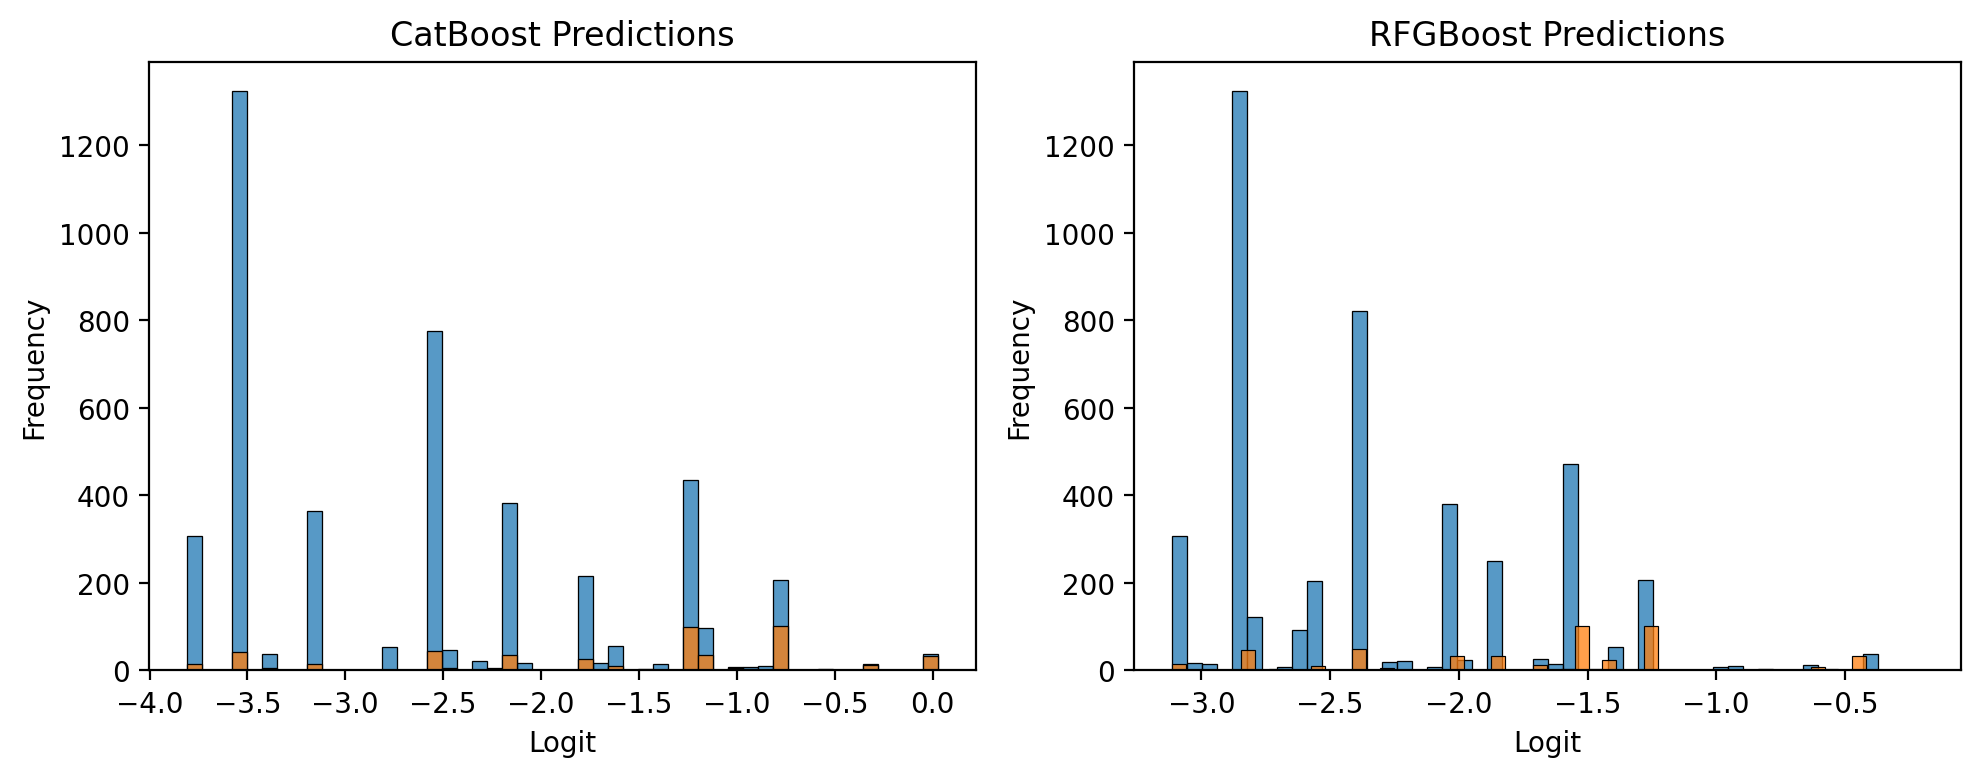

In [11]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
# sns.histplot(cb_pred, bins='scott')
sns.histplot(logit(cb_pred[y_test == 0]), bins=50)
sns.histplot(logit(cb_pred[y_test == 1]), bins=50)
plt.title("CatBoost Predictions")
plt.xlabel("Logit")
plt.ylabel("Frequency")
plt.subplot(1, 2, 2)
sns.histplot(logit(rfgb_pred[y_test == 0]), bins=50)
sns.histplot(logit(rfgb_pred[y_test == 1]), bins=50)
plt.title("RFGBoost Predictions")
plt.xlabel("Logit")
plt.ylabel("Frequency")
plt.tight_layout()

## Uncertainty

We can use built-in uncertainty quantification from random forest.

/Users/deburky/Documents/python/rfgboost/.venv/lib/python3.12/site-packages/colormaps/colormap.py:47: UserWarning: Warning: Number of levels requested is more than the number of colors. Deafulting to maximum number of colors.
  warnings.warn(


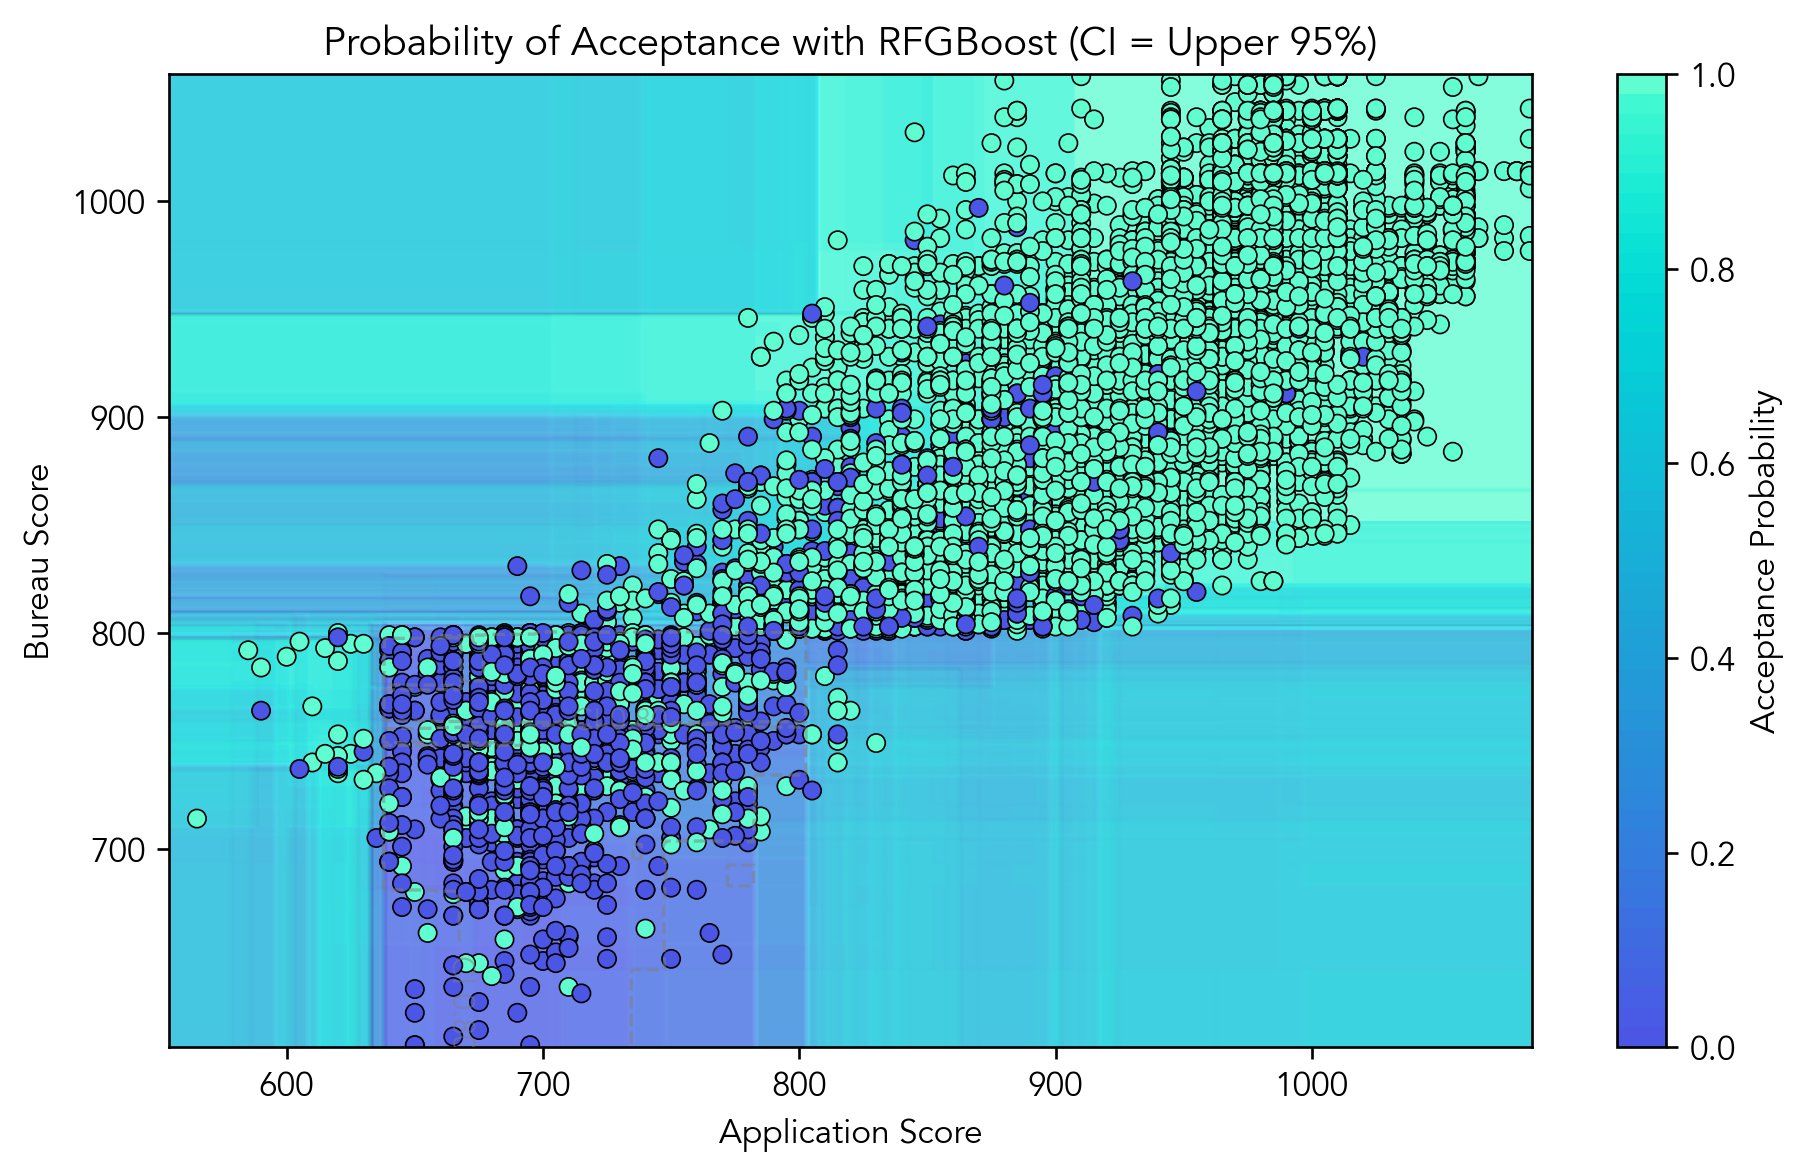

In [12]:
# cmap2 = cmaps.cet_d_cwm_8_r
cmap2 = cmaps.cosmic.shift(0.5).discrete(100)

# Set font to Avenir
plt.rcParams["font.family"] = "Avenir"

# Load dataset
dataset = pd.read_csv(ROOT_DIR / "data" / "BankCaseStudyData.csv")
label = "Final_Decision"

X = dataset[["Application_Score", "Bureau_Score"]]
y = dataset[label].map({"Accept": 1, "Decline": 0})

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Model
model = RFGBoost(
    n_estimators=5,
    rf_params={"n_estimators": 10, "max_depth": 5},
    learning_rate=0.1,
    task="classification",
)
model.fit(X_train, y_train)

# Meshgrid
x_min, x_max = X["Application_Score"].min() - 1, X["Application_Score"].max() + 1
y_min, y_max = X["Bureau_Score"].min() - 1, X["Bureau_Score"].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_df = pd.DataFrame(grid, columns=["Application_Score", "Bureau_Score"])

# Predictions and CIs
Z_mean = model.predict_proba(grid_df)[:, 1].reshape(xx.shape)
ci = model.predict_ci(grid_df, alpha=0.05)
Z_upper = ci[:, 1].reshape(xx.shape)

# Light source shading
ls = LightSource(azdeg=315, altdeg=45)
shaded_surface = ls.shade(Z_mean, cmap=cmap2, vert_exag=3, blend_mode="soft")


# Plot
fig, ax = plt.subplots(figsize=(8, 5), dpi=120)
ax.imshow(
    shaded_surface,
    extent=(x_min, x_max, y_min, y_max),
    origin="lower",
    aspect="auto",
    cmap=cmap2,
    alpha=0.8,
)

# Confidence interval upper bounds as terrain ridges
cont = ax.contour(
    xx,
    yy,
    Z_upper,
    levels=1,
    colors="grey",
    linewidths=1,
    alpha=0.5,
    linestyles="dashed",
)
ax.clabel(cont, inline=True, fontsize=9, fmt="CI %.2f")

# Training data overlay
scatter = ax.scatter(
    X_train["Application_Score"],
    X_train["Bureau_Score"],
    c=y_train,
    cmap=cmap2,
    edgecolor="k",
    linewidth=0.5,
    alpha=1.0,
    s=30,
)

Z_lower = ci[:, 0].reshape(xx.shape)
Z_width = Z_upper - Z_lower

uncertainty_overlay = ax.contourf(xx, yy, Z_width, levels=10, cmap="Greys", alpha=0)
ax.set_xlabel("Application Score")
ax.set_ylabel("Bureau Score")
ax.set_title("Probability of Acceptance with RFGBoost (CI = Upper 95%)")
plt.colorbar(scatter, ax=ax, label="Acceptance Probability")
plt.tight_layout()
plt.show()